In [0]:
import tensorflow as tf
import os
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
import numpy as np
import dill as dpickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline
print(os.getcwd())

from google.colab import drive
drive.mount('/content/gdrive')
!ls

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


In [0]:
!cp gdrive/My\ Drive/ASE\ Project/*.npy .
!ls
test_body_vecs = np.load('test_body_vecs.npy')
test_body_df = pd.DataFrame(test_body_vecs)
print(test_body_df.shape)

gdrive	     test_body_vecs.npy  test_title_vecs.npy  train_labels.npy
sample_data  test_labels.npy	 train_body_vecs.npy  train_title_vecs.npy
(330203, 110)


In [0]:
train_title_vecs = np.load('train_title_vecs.npy')
train_body_vecs = np.load('train_body_vecs.npy')
test_title_vecs = np.load('test_title_vecs.npy')
test_body_vecs = np.load('test_body_vecs.npy')
train_label_vecs = np.load('train_labels.npy')
test_label_vecs = np.load('test_labels.npy')

train_title_df = pd.DataFrame(train_title_vecs)
train_body_df = pd.DataFrame(train_body_vecs)
test_title_df = pd.DataFrame(test_title_vecs)
test_body_df = pd.DataFrame(test_body_vecs)
train_label_df = pd.DataFrame(train_label_vecs)
test_label_df = pd.DataFrame(test_label_vecs)

train_df = pd.concat([train_title_df, train_body_df], axis = 1)
test_df = pd.concat([test_title_df, test_body_df], axis = 1)

print(train_df.shape)
print(test_df.shape)

(1871144, 120)
(330203, 120)


In [0]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

train_df = pd.concat([train_df, train_label_df], axis=1)
test_df = pd.concat([test_df, test_label_df], axis=1)

train_df = shuffle(train_df)
test_df = shuffle(test_df)

train_label_df = train_df.iloc[:, -1]
test_label_df = test_df.iloc[:, -1]
train_df = train_df.iloc[:, :-1]
test_df = test_df.iloc[:, :-1]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.head(500000))
test_scaled = scaler.transform(test_df.head(50000))

print(train_scaled.shape)
print(test_scaled.shape)
print(train_label_df.shape)
print(test_label_df.shape)

(500000, 120)
(50000, 120)
(1871144,)
(330203,)


In [0]:
params_grid = {'criterion':['gini'], 'min_samples_split' : range(150,450,30),'max_depth': range(4,55,3)}

train_label_df = train_label_df.head(500000)
test_label_df = test_label_df.head(50000)
print(train_label_df.shape)
print(test_label_df.shape)


(500000,)
(50000,)


In [0]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(train_scaled)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
test_labels = kmeans.predict(test_scaled)

train_scaled = pd.DataFrame(train_scaled)
test_scaled = pd.DataFrame(test_scaled)

train_scaled[len(train_scaled.columns)] = labels
test_scaled[len(test_scaled.columns)] = test_labels

print(train_scaled.shape)
print(test_scaled.shape)

(500000, 121)
(50000, 121)


In [0]:
train_label = train_label_df.values
test_label = test_label_df.values

dt_model = GridSearchCV(DecisionTreeClassifier(), params_grid, cv=5)

# for plain clustering
# dt_model.fit(labels.reshape(-1, 1), train_label)

dt_model.fit(train_scaled, train_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini'], 'max_depth': range(22, 40, 3),
                         'min_samples_split': range(300, 

In [0]:
print('Best score for training data:', dt_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best max_depth:',dt_model.best_estimator_.max_depth,"\n") 
print('Best criterion:',dt_model.best_estimator_.criterion,"\n")
print('Best min_samples_split:',dt_model.best_estimator_.min_samples_split,"\n")

final_model = dt_model.best_estimator_

# for plain clustering
# Y_pred = final_model.predict(test_labels.reshape(-1, 1))
# Y_pred_train = final_model.predict(labels.reshape(-1, 1))

Y_pred = final_model.predict(test_scaled)
Y_pred_train = final_model.predict(train_scaled)

Best score for training data: 0.597912 

Best max_depth: 25 

Best criterion: gini 

Best min_samples_split: 420 



In [0]:
print(confusion_matrix(test_label_df,Y_pred))

[[14777  7472    67]
 [ 7510 15159   103]
 [ 2582  2175   155]]


In [0]:
print(classification_report(test_label_df,Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.66      0.63     22316
           1       0.61      0.67      0.64     22772
           2       0.48      0.03      0.06      4912

    accuracy                           0.60     50000
   macro avg       0.56      0.45      0.44     50000
weighted avg       0.59      0.60      0.58     50000



In [0]:
from sklearn.metrics import accuracy_score

print("Acc score for test:")
print(accuracy_score(test_label_df,Y_pred))
print("Acc score for train:")
print(accuracy_score(train_label_df,Y_pred_train))

Acc score for test:
0.60182
Acc score for train:
0.640288


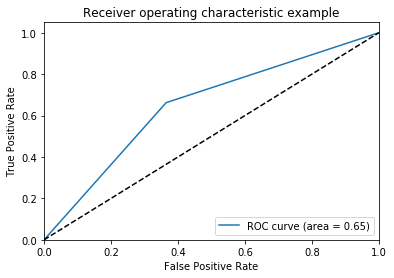

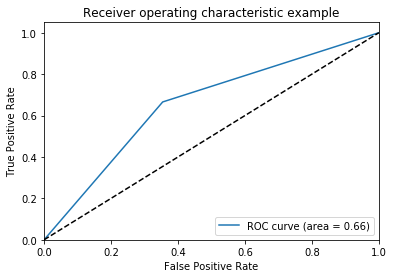

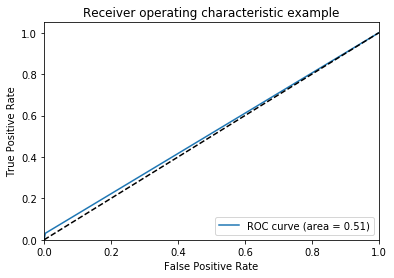

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 3
test_label_df_binary = label_binarize(test_label_df, classes=[0,1,2])
Y_pred_binary = label_binarize(Y_pred, classes=[0,1,2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_label_df_binary[:, i], Y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# create plot
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# save figure
# plt.savefig('roc_curve.png', dpi=200)

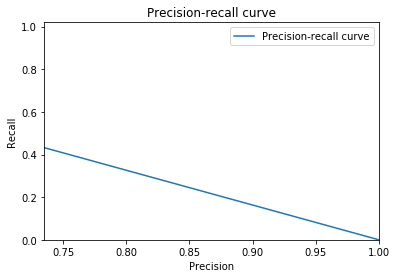

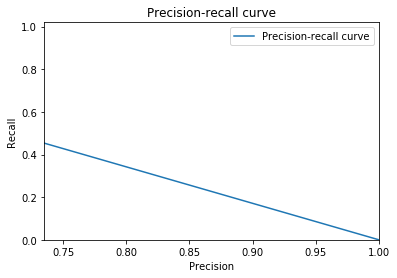

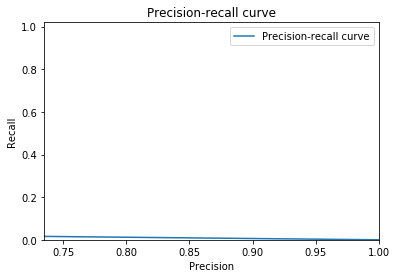

In [0]:
from sklearn.metrics import precision_recall_curve 

precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_label_df_binary[:, i], Y_pred_binary[:, i])

# create plot
for i in range(n_classes):
    plt.figure()
    plt.plot(precision[i], recall[i], label='Precision-recall curve')
    _ = plt.xlabel('Precision')
    _ = plt.ylabel('Recall')
    _ = plt.title('Precision-recall curve')
    _ = plt.xlim([0.735, 1])
    _ = plt.ylim([0, 1.02])
    _ = plt.legend(loc="upper right")
    plt.show()

# save figure
#plt.savefig('precision_recall.png', dpi=200)